# Ridge Regression

To prevent model from *Overfitting*, **Regularization** has been performed. In regularization, normally we keep the same number of features, but reduce the magnitude of the coefficients by introducing a *regularization parameter*. Ridge regression uses a **L2** regularization.

Cost function = $\Vert{X\theta - y}\Vert^2 + \lambda \Vert{\theta}\Vert^2$

An extra term $\lambda$, which is known as the penalty term/regularization has been added. By changing its value, we can control $\theta$. Higher the values of $\lambda$, bigger is the penalty and therefore the magnitude of coefficients ($\theta$) are reduced.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from collections import defaultdict
# to load MATLAB file
import scipy.io as sio
from IPython.display import display, Markdown, Math
from pprint import pprint

%matplotlib inline

### Dataset

In [2]:
dataset = sio.loadmat('rr_dataset')

In [3]:
dataset.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X_trn', 'X_tst', 'Y_trn', 'Y_tst'])

In [4]:
X_train, y_train = np.matrix(dataset['X_trn']), np.matrix(dataset['Y_trn'])
X_test, y_test = np.matrix(dataset['X_tst']), np.matrix(dataset['Y_tst'])

In [5]:
X_train.shape, y_train.shape

((100, 1), (100, 1))

In [6]:
X_test.shape, y_test.shape

((8, 1), (8, 1))

**Adding Intercept term (a column with all 1s) to Feature Vectors**

In [7]:
X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

In [8]:
def computeCost(X, y, theta):
    # Cost fn = (|| Xθ - y||) ^ 2
    inner = np.power((np.dot(X, theta) - y), 2)
    return np.sum(inner) / (2 * len(X))

In [9]:
def MSE(y, y_pred):
    """ Returns mean squared error between the actual and predicted output."""
    return np.mean(np.power((y - y_pred), 2))

In [10]:
def plotCostperEpoch(cost):
    """ plots iteration v/s cost """
    fig, ax = plt.subplots(figsize=(14,8))

    plt.plot(np.arange(len(cost)), cost)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Cost')
    ax.set_title('Error vs. Training Epoch')

## 1) Closed Form Solution Model

In [11]:
def ridgeRegression(X, y, lamb = 1.0):
    """ Solves for weight vector θ using closed form equation
    
    θridge = (X^T*X + lambda * I)^{-1}*X^T*y
    """
    var = np.dot(X.T, X) + np.eye(X.shape[1]) * lamb
    cov = np.dot(X.T, y)
    theta = np.dot(np.linalg.inv(var), cov)
    return theta

## 2) Stochastic Gradient Descent Model

In [12]:
def stochasticGradientDescentRidge(X, y, theta, alpha, minibatch_size, lamb=0,
                                   threshold=0.0001, iters=1000):
    """ optimizes weight vector (theta) with batch of minibatch_size in each iteration,
    until convergence
    
    """

    # to store temp theta to perform simultaneous update in current iteration
    temp = np.matrix(np.zeros(theta.shape))
    parameters = theta.ravel().shape[1]
    cost = [np.inf]
    
    while True:
        # iterating over feature matrix in batches
        for b in range(math.ceil(len(X)/minibatch_size)):
            # generates random samples without replacement, all unique
            random_idx = np.random.choice(len(X), size=min(len(X), minibatch_size), replace = False)

            # Get pair of (X, y) of the current minibatch/chunk
            X_mini = X[random_idx]
            y_mini = y[random_idx]
            
            error = (X_mini * theta) - y_mini
            
            # updated each parameter/weight in theta
            for j in range(parameters):
                # training element-wise multiplication of jth feature with the error
                term = np.multiply(error, X_mini[:,j])
                temp[j, 0] = theta[j, 0] - ((alpha / len(X_mini)) * (np.sum(term) + lamb * theta[j, 0]))

            theta = temp
            
        cost.append(computeCost(X, y, theta))
        
        # check for convergence, i.e. if difference is cost within threshold
        if (cost[-2]-cost[-1]) > 0 and (cost[-2]-cost[-1]) < threshold:
            break
        
    return theta, cost

### Tuning the Hyperparameter for Regularization ($\lambda$):

Optimal $\lambda$: Minimum mean holdout set error

In [13]:
lambda_list = [0.03, 0.1, 0.3, 1, 3]

In [14]:
def regularizationParameter(X, y, kfolds, alpha, minibatch_size, threshold=0.0001, 
                            lambda_list = lambda_list):
    """ finds the optimal lambda from lambda_list
    
    optimal lambda will be the one with minimum mean error on holdout set
    """
    theta0 = np.matrix(np.zeros((X.shape[1], 1)))
    
    shuffled_idx = np.random.choice(len(X), size=len(X), replace = False)
    idx_per_fold = round(len(X)/kfolds)
    if len(X) % kfolds != 0:
        kfolds += 1
        
    lambda_errorlist = defaultdict(list)
    
    for lamb in lambda_list:
        # divides data into k-folds
        for k in range(kfolds):
            #holdout_idx = np.arange(k*idx_per_fold, (k+1)*idx_per_fold)
            holdout_idx = shuffled_idx[k*idx_per_fold : (k+1)*idx_per_fold]
            #X_holdout = X[k*idx_per_fold : (k+1)*idx_per_fold]
            #X_training = np.delete(X,holdout_idx, axis=0)
            # Holdout data - kth fold
            X_holdout = X[holdout_idx]
            y_holdout = y[holdout_idx]
            # Training data - other than kth fold
            X_training = X[~holdout_idx]
            y_training = y[~holdout_idx]
            
            thetalk, _ = stochasticGradientDescentRidge(X_training, y_training, theta0, 
                                                        alpha, minibatch_size, lamb, threshold)
            # error on the kth holdout set
            holdout_error_lk = computeCost(X_holdout, y_holdout, thetalk)
            
            lambda_errorlist[lamb].append(holdout_error_lk)
            # print("{0}th holdout error(λ={1}): {2}".format(k, lamb, holdout_error_lk))
            
    pprint(dict(lambda_errorlist))
    # find optimal lambda i.e. with mimimum mean error on k holdout sets
    lambda_optimal = min(lambda_errorlist, key= lambda l: np.mean(lambda_errorlist[l]))
    
    return lambda_optimal

### 1) Modelling the Parameter $\theta$ : 2-Folds for tuning $\lambda$

In [15]:
kfolds_2 = 2

### 1.a) 2-degree Polynomial

In [16]:
# adding quadratic term to the feature matrix
X_train_2d = np.hstack((X_train, np.power(X_train[:, 1:], 2)))
X_test_2d = np.hstack((X_test, np.power(X_test[:, 1:], 2)))

**Closed-form**

In [17]:
theta_2d_closed = ridgeRegression(X_train_2d, y_train)
display(Markdown(r'$\theta_{ridge}$' + ' for 2-degree polynomial (Closed-form)'))
display(theta_2d_closed)

$\theta_{ridge}$ for 2-degree polynomial (Closed-form)

matrix([[29.96240203],
        [13.51059923],
        [-0.30515645]])

In [18]:
y_train_predict_2d_closed = np.dot(X_train_2d, theta_2d_closed)
print("MSE for Training set for 2-degree polynomial: {0:.4f}"
      .format(MSE(np.asarray(y_train), np.asarray(y_train_predict_2d_closed))))

y_test_predict_2d_closed = np.dot(X_test_2d, theta_2d_closed)
print("MSE for Test set for 2-degree polynomial: {0:.4f}"
      .format(MSE(np.asarray(y_test), np.asarray(y_test_predict_2d_closed))))

MSE for Training set for 2-degree polynomial: 868.4131
MSE for Test set for 2-degree polynomial: 1746.5616


**Mini-batch Gradient Descent**

In [19]:
alpha = 0.00001
minibatch_size = 5

lambda_optimal_2k2d = regularizationParameter(X_train_2d, y_train, kfolds_2, alpha, minibatch_size)
print("Optimal lambda with 2-folds on 2-degree polynomial data: {}".format(lambda_optimal_2k2d))

{0.03: [441.8064709165033, 685.6945794116552],
 0.1: [481.95745723982986, 649.70745213292],
 0.3: [398.81790501531776, 701.8915856713564],
 1: [411.4911434338769, 689.2419190248943],
 3: [410.7077902858789, 733.5208979481]}
Optimal lambda with 2-folds on 2-degree polynomial data: 0.3


In [20]:
theta0_2d = np.matrix(np.zeros((X_train_2d.shape[1], 1)))
display(Markdown(r'Initial  $\theta_{ridge}$ = ') , theta0_2d)

Initial  $\theta_{ridge}$ = 

matrix([[0.],
        [0.],
        [0.]])

In [21]:
theta_2d_sg, cost_2d_sg = stochasticGradientDescentRidge(X_train_2d, y_train, theta0_2d, alpha, 
                                                         minibatch_size, lambda_optimal_2k2d)
display(Markdown(r'$\theta_{ridge}$' + ' for 2-degree polynomial (Minibatch Gradient Descent)'))
display(theta_2d_sg)

$\theta_{ridge}$ for 2-degree polynomial (Minibatch Gradient Descent)

matrix([[11.07727488],
        [14.09759736],
        [ 0.34645472]])

In [22]:
y_train_predict_2d_sg = np.dot(X_train_2d, theta_2d_sg)
mse_train_2d_sg = MSE(np.asarray(y_train), np.asarray(y_train_predict_2d_sg))
print("MSE for Training set for 2-degree poynomial (2-folds): {0:.4f}".format(mse_train_2d_sg))

y_test_predict_2d_sg = np.dot(X_test_2d, theta_2d_sg)
mse_test_2d_sg = MSE(np.asarray(y_test), np.asarray(y_test_predict_2d_sg))
print("MSE for Test set for 2-degree poynomial (2-folds): {0:.4f}".format(mse_test_2d_sg))

MSE for Training set for 2-degree poynomial (2-folds): 1035.0440
MSE for Test set for 2-degree poynomial (2-folds): 1651.0098


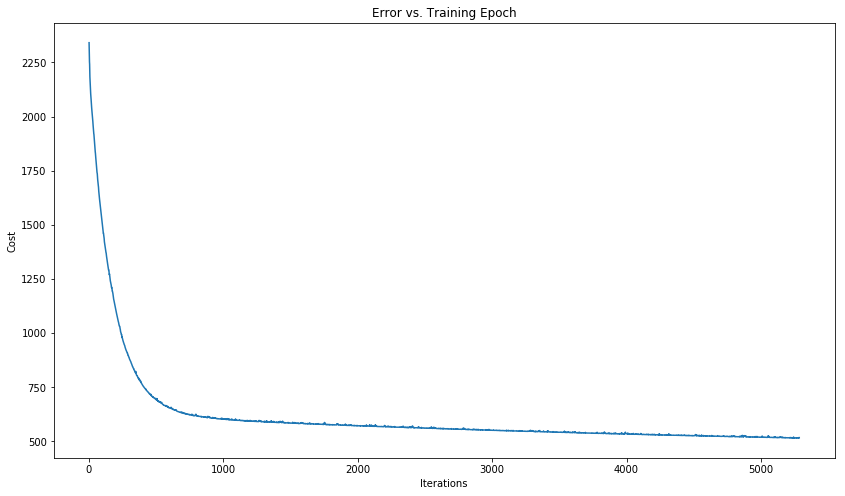

In [23]:
plotCostperEpoch(cost_2d_sg)

### 1.b) 3-degree Polynomial

In [24]:
# adding quadratic and cubic term to the feature matrix
X_train_3d = np.hstack((X_train, np.power(X_train[:, 1:], 2), np.power(X_train[:, 1:], 3)))
X_test_3d = np.hstack((X_test, np.power(X_test[:, 1:], 2), np.power(X_test[:, 1:], 3)))

**Closed-form**

In [25]:
theta_3d_closed = ridgeRegression(X_train_3d, y_train)
display(Markdown(r'$\theta_{ridge}$' + ' for 3-degree polynomial (Closed-form)'))
display(theta_3d_closed)

$\theta_{ridge}$ for 3-degree polynomial (Closed-form)

matrix([[ 9.59691477],
        [-0.8820544 ],
        [ 1.41233801],
        [ 0.51139925]])

In [26]:
y_train_predict_3d_closed = np.dot(X_train_3d, theta_3d_closed)
print("MSE for Training set for 3-degree poynomial: {0:.4f}"
      .format(MSE(np.asarray(y_train), np.asarray(y_train_predict_3d_closed))))

y_test_predict_3d_closed = np.dot(X_test_3d, theta_3d_closed)
print("MSE for Test set for 3-degree poynomial: {0:.4f}"
      .format(MSE(np.asarray(y_test), np.asarray(y_test_predict_3d_closed))))

MSE for Training set for 3-degree poynomial: 44.2774
MSE for Test set for 3-degree poynomial: 210.1724


**Mini-batch Gradient Descent**

In [27]:
alpha = 0.0000001
minibatch_size = 5

lambda_optimal_2k3d = regularizationParameter(X_train_3d, y_train, kfolds_2, alpha, minibatch_size)
print("Optimal lambda with 2-folds on 3-degree polynomial data: {}".format(lambda_optimal_2k3d))

{0.03: [44.67013446882804, 87.69622414069528],
 0.1: [72.84446941904758, 99.42482822466984],
 0.3: [47.26750006180812, 81.6216764186088],
 1: [46.69461125203407, 75.12073779058443],
 3: [38.80014565325728, 89.65968432560884]}
Optimal lambda with 2-folds on 3-degree polynomial data: 1


In [28]:
theta0_3d = np.matrix(np.zeros((X_train_3d.shape[1], 1)))
display(Markdown(r'Initial  $\theta_{ridge}$ = ') , theta0_3d)

Initial  $\theta_{ridge}$ = 

matrix([[0.],
        [0.],
        [0.],
        [0.]])

In [29]:
theta_3d_sg, cost_3d_sg = stochasticGradientDescentRidge(X_train_3d, y_train, theta0_3d, alpha, 
                                                         minibatch_size, lambda_optimal_2k3d)
display(Markdown(r'$\theta_{ridge}$' + ' for 3-degree polynomial (Minibatch Gradient Descent)'))
display(theta_3d_sg)

$\theta_{ridge}$ for 3-degree polynomial (Minibatch Gradient Descent)

matrix([[0.08649502],
        [0.02899012],
        [1.59235573],
        [0.49301788]])

In [30]:
y_train_predict_3d_sg = np.dot(X_train_3d, theta_3d_sg)
mse_train_3d_sg = MSE(np.asarray(y_train), np.asarray(y_train_predict_3d_sg))
print("MSE for Training set for 3-degree poynomial (2-folds): {0:.4f}".format(mse_train_3d_sg))

y_test_predict_3d_sg = np.dot(X_test_3d, theta_3d_sg)
mse_test_3d_sg = MSE(np.asarray(y_test), np.asarray(y_test_predict_3d_sg))
print("MSE for Test set for 3-degree poynomial (2-folds): {0:.4f}".format(mse_test_3d_sg))

MSE for Training set for 3-degree poynomial (2-folds): 96.1018
MSE for Test set for 3-degree poynomial (2-folds): 284.0777


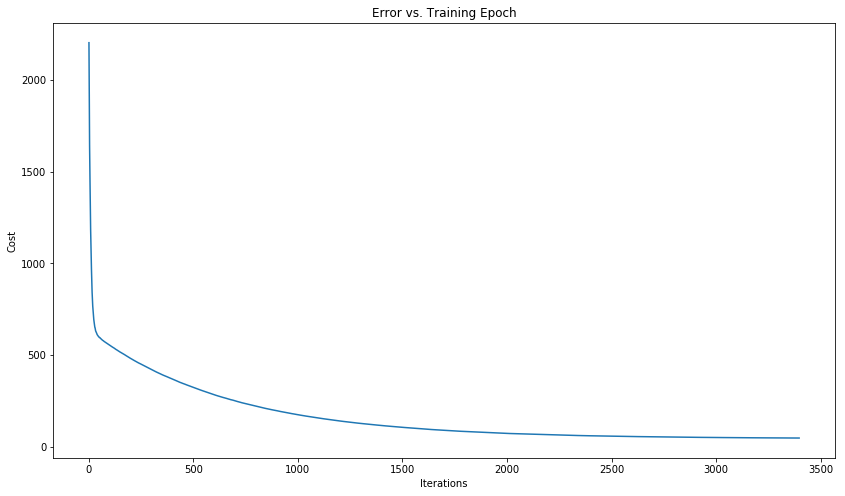

In [31]:
plotCostperEpoch(cost_3d_sg)

### 1.c) 5-degree Polynomial

In [32]:
X_train_5d = np.hstack((X_train, np.power(X_train[:, 1:], 2), np.power(X_train[:, 1:], 3),
                        np.power(X_train[:, 1:], 4), np.power(X_train[:, 1:], 5)))
X_test_5d = np.hstack((X_test, np.power(X_test[:, 1:], 2), np.power(X_test[:, 1:], 3), 
                       np.power(X_test[:, 1:], 4), np.power(X_test[:, 1:], 5)))

**Closed-form**

In [33]:
theta_5d_closed = ridgeRegression(X_train_5d, y_train)
display(Markdown(r'$\theta_{ridge}$' + ' for 5-degree polynomial (Closed-form)'))
display(theta_5d_closed)

$\theta_{ridge}$ for 5-degree polynomial (Closed-form)

matrix([[1.02564432e+01],
        [7.53741068e-02],
        [1.18688844e+00],
        [4.19667762e-01],
        [7.84185555e-03],
        [1.86444160e-03]])

In [34]:
y_train_predict_5d_closed = np.dot(X_train_5d, theta_5d_closed)
print("MSE for Training set for 5-degree poynomial: {0:.4f}"
      .format(MSE(np.asarray(y_train), np.asarray(y_train_predict_5d_closed))))

y_test_predict_5d_closed = np.dot(X_test_5d, theta_5d_closed)
print("MSE for Test set for 5-degree poynomial: {0:.4f}"
      .format(MSE(np.asarray(y_test), np.asarray(y_test_predict_5d_closed))))

MSE for Training set for 5-degree poynomial: 42.4199
MSE for Test set for 5-degree poynomial: 208.5669


**Mini-batch Gradient Descent**

In [35]:
alpha = 0.0000000001
minibatch_size = 10
threshold = 0.00001

lambda_optimal_2k5d = regularizationParameter(X_train_5d, y_train, kfolds_2, alpha, 
                                              minibatch_size, threshold)
print("Optimal lambda with 2-folds on 5-degree polynomial data: {}".format(lambda_optimal_2k5d))

{0.03: [372.3465733852374, 126.43146093782102],
 0.1: [301.3745608225818, 124.68980629413937],
 0.3: [163.8703065170658, 127.03750617108561],
 1: [166.49791074042776, 125.20297838545854],
 3: [501.67438651731186, 189.70764328252957]}
Optimal lambda with 2-folds on 5-degree polynomial data: 0.3


In [36]:
alpha = 0.0000000001
minibatch_size = 5
threshold = 0.00001

theta0_5d = np.matrix(np.zeros((X_train_5d.shape[1], 1)))
display(Markdown(r'Initial  $\theta_{ridge}$ = ') , theta0_5d)

Initial  $\theta_{ridge}$ = 

matrix([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])

In [37]:
theta_5d_sg, cost_5d_sg = stochasticGradientDescentRidge(X_train_5d, y_train, theta0_5d, alpha,
                                                         minibatch_size, lambda_optimal_2k5d, threshold)
display(Markdown(r'$\theta_{ridge}$' + ' for 5-degree polynomial (Minibatch Gradient Descent)'))
display(theta_5d_sg)

$\theta_{ridge}$ for 5-degree polynomial (Minibatch Gradient Descent)

matrix([[0.00019583],
        [0.00067981],
        [0.00223841],
        [0.0116816 ],
        [0.06998688],
        [0.01413955]])

In [38]:
y_train_predict_5d_sg = np.dot(X_train_5d, theta_5d_sg)
mse_train_5d_sg = MSE(np.asarray(y_train), np.asarray(y_train_predict_5d_sg))
print("MSE for Training set for 5-degree poynomial (2-folds): {0:.4f}".format(mse_train_5d_sg))

y_test_predict_5d_sg = np.dot(X_test_5d, theta_5d_sg)
mse_test_5d_sg = MSE(np.asarray(y_test), np.asarray(y_test_predict_5d_sg))
print("MSE for Test set for 5-degree poynomial (2-folds): {0:.4f}".format(mse_test_5d_sg))

MSE for Training set for 5-degree poynomial (2-folds): 263.8187
MSE for Test set for 5-degree poynomial (2-folds): 808.2390


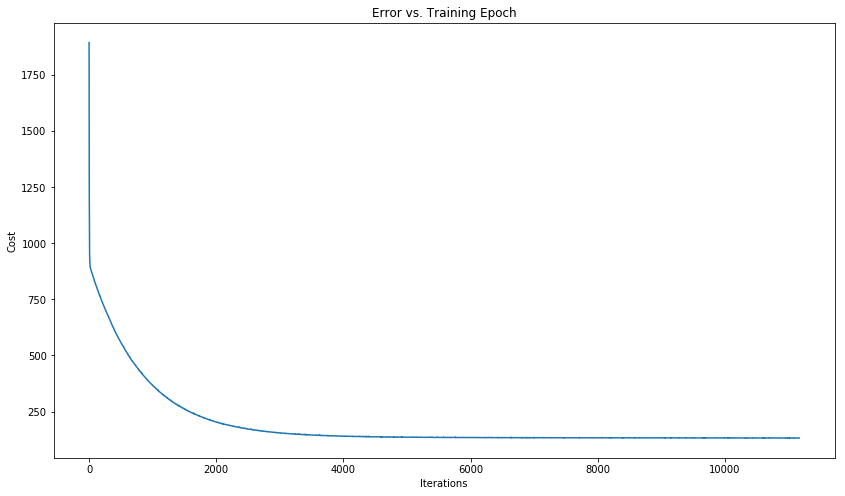

In [39]:
plotCostperEpoch(cost_5d_sg)

## MSE w.r.t. Number of features

In [40]:
x_data = [2, 3, 5]
y_train_data = [mse_train_2d_sg, mse_train_3d_sg, mse_train_5d_sg]
y_test_data = [mse_test_2d_sg, mse_test_3d_sg, mse_test_5d_sg]

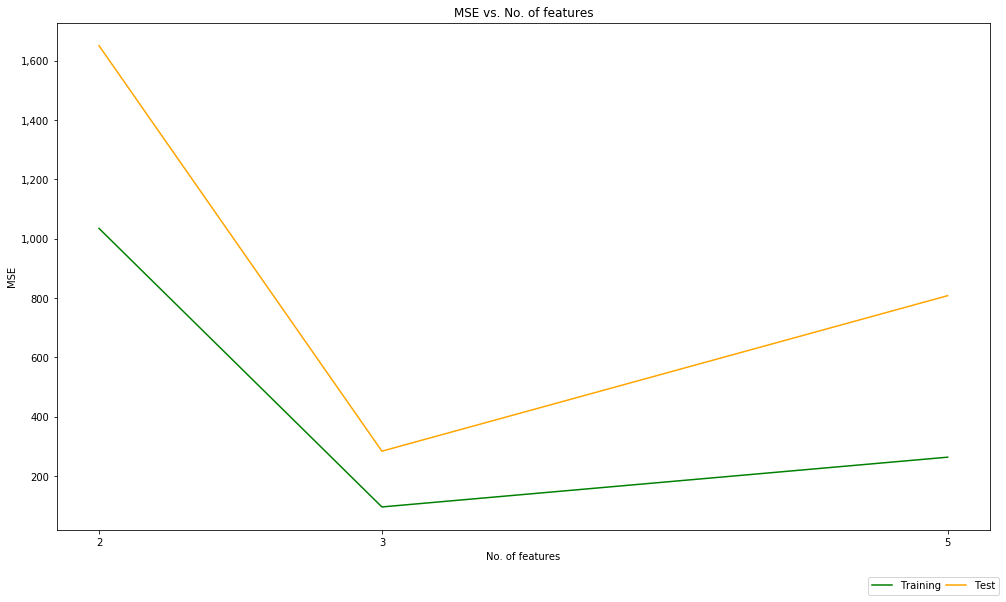

In [41]:
import matplotlib.ticker as tkr

fig, ax = plt.subplots(figsize=(14,8))

plt.plot(x_data, y_train_data, color='green', label='Training')
plt.plot(x_data, y_test_data, color='orange', label='Test')

ax.set_xlabel('No. of features')
ax.set_ylabel('MSE')
ax.set_title('MSE vs. No. of features')

ax.set_xticks(x_data)                   # Set the locations of the tick marks
ax.set_xticklabels(x_data)              # Set the text values of the tick labels

ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))

fig.tight_layout()

plt.legend(bbox_to_anchor=(1, 0), loc="upper right", bbox_transform=fig.transFigure,
           ncol=2, columnspacing=0.5)
plt.show()

3 seems to be a good number of features with best performance on test data.